In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

# Dataset

---

We import the data and convert the distance modulus to distance.

In [2]:
df = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', comment='#', sep=r'\s+', header=None)
df

,0,1,2,3,4
0,1993ah,0.028488,35.346583,0.223906,0.128419
1,1993ag,0.050043,36.682368,0.166829,0.128419
2,1993o,0.052926,36.817691,0.155756,0.128419
3,1993b,0.070086,37.446737,0.158467,0.128419
4,1992bs,0.062668,37.483409,0.156099,0.128419
...,...,...,...,...,...
575,D-000,1.017000,44.293971,0.171046,0.000015
576,D-006,1.315000,44.971358,0.187509,0.551672
577,P-009,0.821000,43.640939,0.194014,0.551672
578,R-012,1.215000,45.246521,0.560317,0.000148


We convert the distance modulus to distance by
$$
d
= 10^{(\mu + 5)/5}\, \mathrm{pc}
= 10^{(\mu + 5)/5 - 6}\, \mathrm{Mpc}.
$$

In [3]:
data = df.iloc[:, [1, 2]]
data.iloc[:, 1] = 10**((data.iloc[:, 1] + 5)/5 - 6) # convert distance modulus to distance [Mpc]
data

,1,2
0,0.028488,117.305042
1,0.050043,217.006920
2,0.052926,230.960787
3,0.070086,308.565458
4,0.062668,313.820905
...,...,...
575,1.017000,7224.273081
576,1.315000,9868.963776
577,0.821000,5347.955161
578,1.215000,11202.222383


We only use samples with small redshifts ($z<1$) because:

- For large $z$, the Hubble law would be more complicated due a more complicated expansion history for the light traveling from the source to us;
- We may use the approximation $v\approx cz$.

There are still plenty of data.

In [4]:
# data with z < 0.1
local_data = data[data.iloc[:, 0].astype(float) < 0.1]
local_data

,1,2
0,0.028488,117.305042
1,0.050043,217.006920
2,0.052926,230.960787
3,0.070086,308.565458
4,0.062668,313.820905
...,...,...
252,0.066440,298.140524
265,0.089019,367.866793
271,0.093149,453.088193
274,0.085696,396.970599


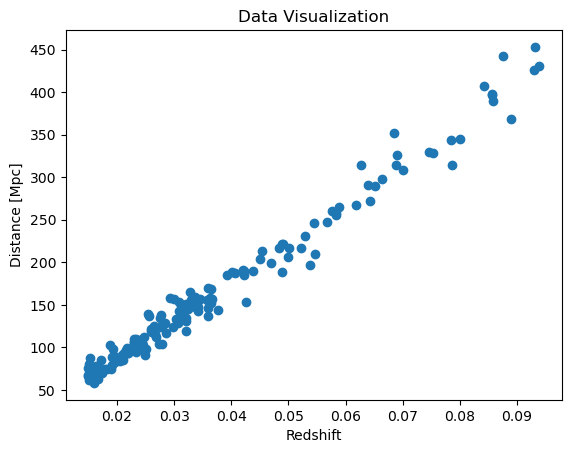

In [5]:
plt.scatter(local_data.iloc[:, 0], local_data.iloc[:, 1])
plt.xlabel('Redshift')
plt.ylabel('Distance [Mpc]')
plt.title('Data Visualization');

# Model

---

For nearby celestial objects, the recession speed is much lesser than the speed of light, that is, $v \ll c$. We may thus use the approximation of the Doppler shift formula $v = cz$.

On the other hand, Hubble's law says
$$
v = H_0 d.
$$
Thus,
$$
d = \frac{c}{H_0} z.
$$

We model our data to have the relation
$$
d = \beta_0 + \beta_1 z + \epsilon,
$$
where $\beta$ and $\epsilon$ all has units of $\mathrm{Mpc}$. Hence, the Hubble parameter is estimated as
$$
\hat H_0 = \frac{c}{\beta_1} = \frac{3*10^5 \, \mathrm{km/s}}{\beta_1},
$$
with units of $\mathrm{km/s/Mpc}$.

# Regression

---

## Model 1: standard model

In this model we assume basically no prior knowledge on the Hubble law, so we simply do a standard linear regression on our data. In Model 2 we will set the intercept term to be $0$, which is more physically motivated.

In [74]:
# linear regression model

X = local_data.iloc[:, 0].values
X = np.column_stack((np.ones(len(X)), X))
Y = local_data.iloc[:, 1].values
n, p = X.shape



# MLE

beta_MLE = np.linalg.inv(X.T @ X) @ X.T @ Y
SSE = (Y - X @ beta_MLE).T @ (Y - X @ beta_MLE)
lambda_MLE = n/SSE
MSE = SSE/(n - p)

print(f'MLE for β: {beta_MLE} Mpc')
print(f'MLE for λ: {lambda_MLE} Mpc^{{-2}}')
print(f'MLE for H_0: {3e5/beta_MLE[-1]} km/s/Mpc')

MLE for β: [-3.93144678e+00  4.55416140e+03] Mpc
MLE for λ: 0.005924987658004681 Mpc^{-2}
MLE for H_0: 65.87381819553858 km/s/Mpc


### MCMC

Here we run a Gibbs sampler as our MCMC sampler. We use an independent refrence prior of
$$
\beta
\sim \mathrm N_2 (m, c^{-1} I_2)
= \mathrm N_2 (\beta_\mathrm{MLE}, 10^3 I_2),
$$
$$
\lambda
\sim \mathrm{Gamma} (a, b)
= \mathrm{Gamma} (10^{-3} \lambda_\mathrm{MLE}, 10^{-3}),
$$
which ensures that the mean values are consistent with the MLEs and the variance is large ($1000$ and $1000 \lambda_\mathrm{MLE}$).

/var/folders/9f/b1rt2w8d66n9t8vwlyv60yd00000gn/T/ipykernel_92157/1112377593.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  Y = np.random.normal(loc=X @ beta, scale=1/np.sqrt(lambda_), size=1)


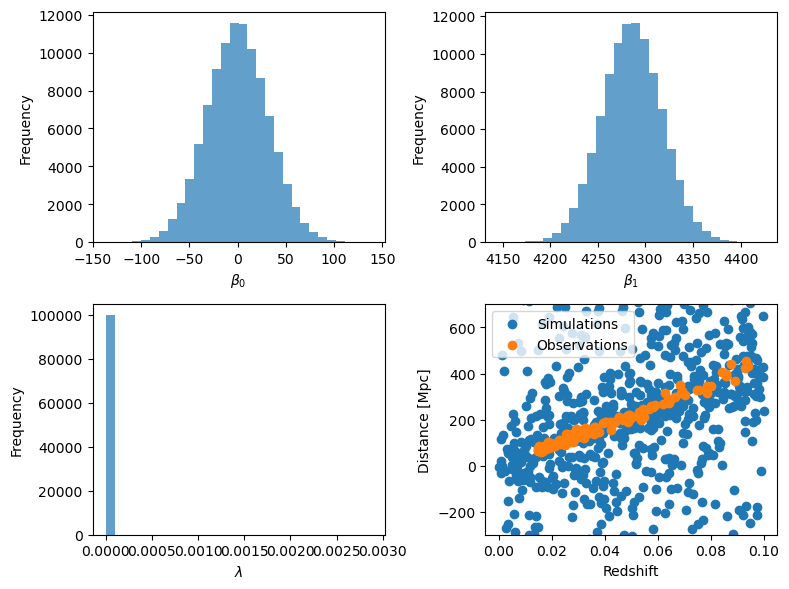

In [46]:
# prior predictive check

n_samples = 100000

# draw beta and lambda
beta_samples = np.random.multivariate_normal(mean=np.array([0, 3e5 / 70]), cov=1e3 * np.eye(2), size=n_samples)
lambda_samples = np.random.gamma(shape=1e-3, scale=1e-3, size=n_samples)

# draw y
X = np.ones(2)
Y_samples = []
for i in range(n_samples):
    beta = beta_samples[i]
    lambda_ = lambda_samples[i]

    X[1] = (i + 1)*0.1/n_samples # X doesn't need to be random
    Y = np.random.normal(loc=X @ beta, scale=1/np.sqrt(lambda_), size=1)
    Y_samples.append(Y)
Y_samples = np.array(Y_samples)



plt.figure(figsize=(8, 6))

# samples of beta
plt.subplot(2, 2, 1)
plt.hist(beta_samples[:, 0], bins=30, alpha=0.7)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(beta_samples[:, 1], bins=30, alpha=0.7)
plt.xlabel(r'$\beta_1$')
plt.ylabel('Frequency')

# samples of lambda
plt.subplot(2, 2, 3)
plt.hist(lambda_samples, bins=30, alpha=0.7)
plt.xlabel(r'$\lambda$')
plt.ylabel('Frequency')

# samples of y
plt.subplot(2, 2, 4)
plt.scatter(np.linspace(0, 0.1, n_samples + 1)[1:], Y_samples, label='Simulations')
plt.scatter(local_data.iloc[:, 0], local_data.iloc[:, 1], label='Observations')
plt.ylim(-300, 700)
plt.xlabel('Redshift')
plt.ylabel('Distance [Mpc]')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
# Gibbs sampler

n_samples = int(1e5)

# prior parameters (we choose the mean according to the MLE)
m = np.array([0, 3e5 / 70])
c = 1e-3
a = 1e-3
b = 1e-3

# initial values
beta = beta_MLE
lambda_ = lambda_MLE

shape = a + n/2

beta_samples = []
lambda_samples = []

for i in range(n_samples):
    # beta | lambda, Y, X
    cov = np.linalg.inv(c * np.eye(p) + lambda_ * X.T @ X)
    mean = cov @ (lambda_ * X.T @ Y + c * m)
    beta = stats.multivariate_normal.rvs(mean=mean, cov=cov)

    # lambda | beta, Y, X
    scale = 2/(2*b + (Y - X @ beta).T @ (Y - X @ beta)) # note the difference in convention for SciPy
    lambda_ = stats.gamma.rvs(a=shape, scale=scale)

    beta_samples.append(beta)
    lambda_samples.append(lambda_)

beta_samples = np.array(beta_samples)
lambda_samples = np.array(lambda_samples)

Posterior mean: 3.100435032651676


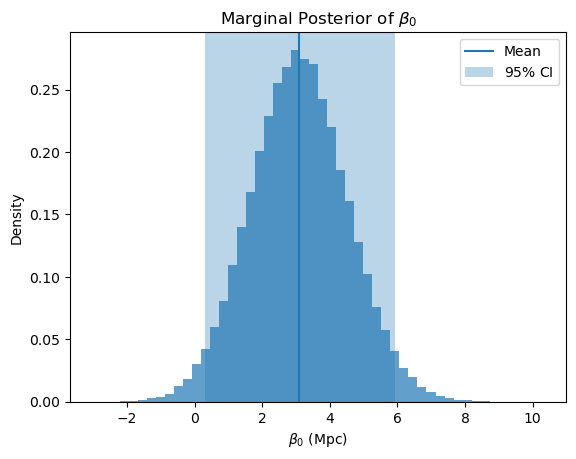

Posterior mean: 4358.18693862924


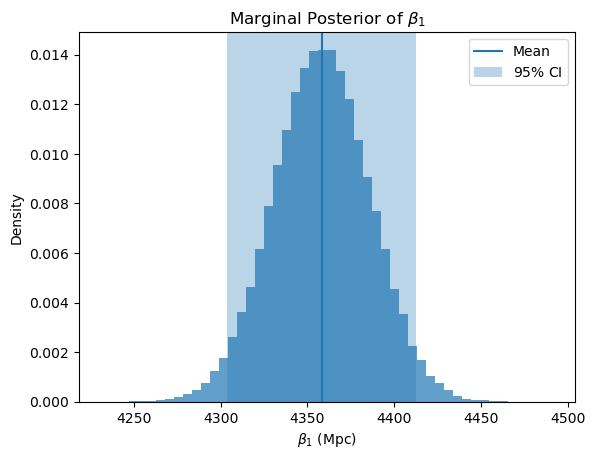

Posterior mean: 0.0054021937845963545


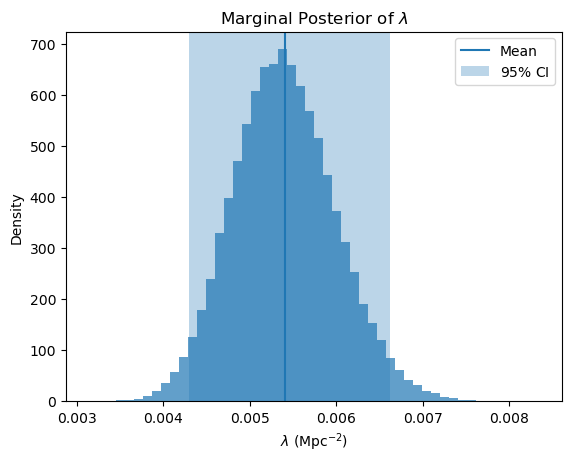

In [76]:
# results

# beta
beta_mean = np.zeros(p)
for i in range(p):
    beta_mean[i] = beta_samples[:, i].mean()
    beta1_CI = np.percentile(beta_samples[:, i], [2.5, 97.5])
    print('Posterior mean:', beta_mean[i])

    plt.figure()
    plt.hist(beta_samples[:, i], bins=50, density=True, alpha=0.7)
    plt.axvline(beta_mean[i], label='Mean')
    plt.axvspan(beta1_CI[0], beta1_CI[1], alpha=0.3, label=r'$95\%$ CI')
    plt.title(rf'Marginal Posterior of $\beta_{i}$')
    plt.xlabel(rf'$\beta_{i}$ (Mpc)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# lambda
lambda_mean = lambda_samples.mean()
lambda_CI = np.percentile(lambda_samples, [2.5, 97.5])
print('Posterior mean:', lambda_mean)

plt.figure()
plt.hist(lambda_samples, bins=50, density=True, alpha=0.7)
plt.axvline(lambda_mean, label='Mean')
plt.axvspan(lambda_CI[0], lambda_CI[1], alpha=0.3, label=r'$95\%$ CI')
plt.title(r'Marginal Posterior of $\lambda$')
plt.xlabel(r'$\lambda$ ($\mathrm{Mpc}^{-2}$)')
plt.ylabel('Density')
plt.legend()
plt.show()

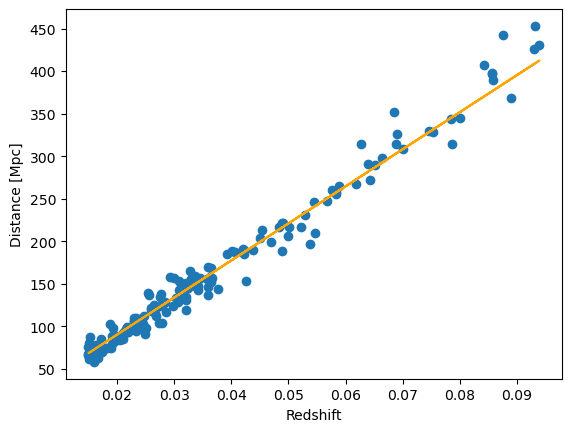

In [77]:
plt.scatter(X[:, 1], Y)
plt.plot(X[:, 1], beta_mean[0] + beta_mean[1]*X[:, 1], color='orange')
plt.xlabel('Redshift')
plt.ylabel('Distance [Mpc]');

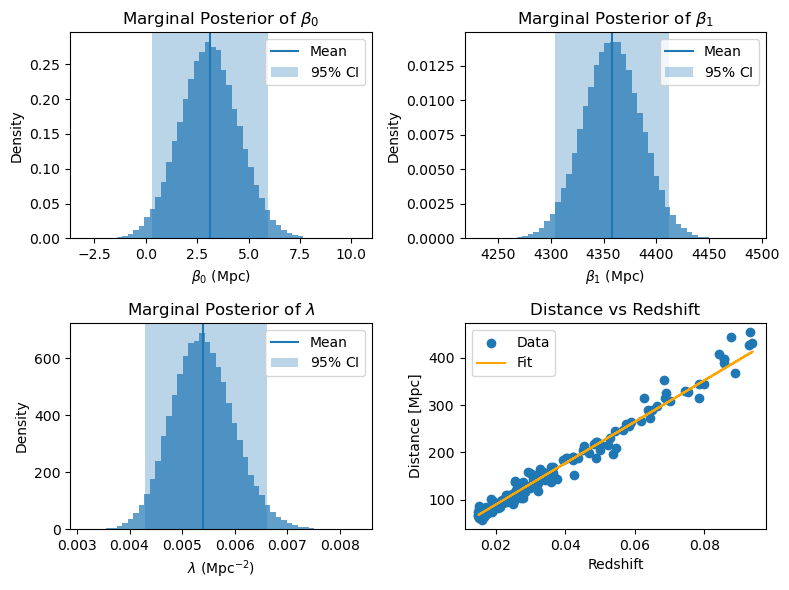

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

# 初始化 beta 均值
beta_mean = np.zeros(p)

# 图1: Marginal Posterior of beta_0
beta_mean[0] = beta_samples[:, 0].mean()
beta1_CI = np.percentile(beta_samples[:, 0], [2.5, 97.5])
axs[0].hist(beta_samples[:, 0], bins=50, density=True, alpha=0.7)
axs[0].axvline(beta_mean[0], label='Mean')
axs[0].axvspan(beta1_CI[0], beta1_CI[1], alpha=0.3, label=r'$95\%$ CI')
axs[0].set_title(rf'Marginal Posterior of $\beta_0$')
axs[0].set_xlabel(rf'$\beta_0$ (Mpc)')
axs[0].set_ylabel('Density')
axs[0].legend()

# 图2: Marginal Posterior of beta_1
beta_mean[1] = beta_samples[:, 1].mean()
beta2_CI = np.percentile(beta_samples[:, 1], [2.5, 97.5])
axs[1].hist(beta_samples[:, 1], bins=50, density=True, alpha=0.7)
axs[1].axvline(beta_mean[1], label='Mean')
axs[1].axvspan(beta2_CI[0], beta2_CI[1], alpha=0.3, label=r'$95\%$ CI')
axs[1].set_title(rf'Marginal Posterior of $\beta_1$')
axs[1].set_xlabel(rf'$\beta_1$ (Mpc)')
axs[1].set_ylabel('Density')
axs[1].legend()

# 图3: Marginal Posterior of lambda
lambda_mean = lambda_samples.mean()
lambda_CI = np.percentile(lambda_samples, [2.5, 97.5])
axs[2].hist(lambda_samples, bins=50, density=True, alpha=0.7)
axs[2].axvline(lambda_mean, label='Mean')
axs[2].axvspan(lambda_CI[0], lambda_CI[1], alpha=0.3, label=r'$95\%$ CI')
axs[2].set_title(r'Marginal Posterior of $\lambda$')
axs[2].set_xlabel(r'$\lambda$ ($\mathrm{Mpc}^{-2}$)')
axs[2].set_ylabel('Density')
axs[2].legend()

# 图4: Distance vs Redshift
axs[3].scatter(X[:, 1], Y, label='Data')
axs[3].plot(X[:, 1], beta_mean[0] + beta_mean[1]*X[:, 1], color='orange', label='Fit')
axs[3].set_xlabel('Redshift')
axs[3].set_ylabel('Distance [Mpc]')
axs[3].set_title('Distance vs Redshift')
axs[3].legend()

# 调整布局
plt.tight_layout()
plt.show()

We may now estimate $H_0$.

Posterior mean: 68.8387430202634 km/s/Mpc
95% credible interval: [67.99376417669366, 69.70677820080874] km/s/Mpc


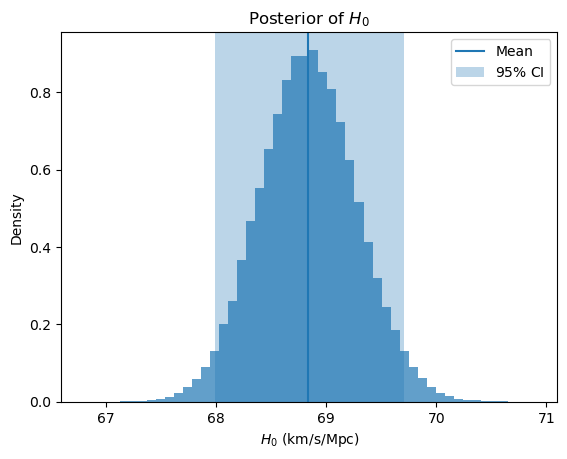

In [82]:
H0_samples = 3e5/beta_samples[:, 1]

H0_mean = H0_samples.mean()
H0_CI = np.percentile(H0_samples, [2.5, 97.5])
print(f'Posterior mean: {H0_mean} km/s/Mpc')
print(f'95% credible interval: [{H0_CI[0]}, {H0_CI[1]}] km/s/Mpc')

plt.hist(H0_samples, bins=50, density=True, alpha=0.7)
plt.axvline(H0_mean, label='Mean')
plt.axvspan(H0_CI[0], H0_CI[1], alpha=0.3, label=r'$95\%$ CI')
plt.title(r'Posterior of $H_0$')
plt.xlabel(r'$H_0$ ($\mathrm{km}/\mathrm{s}/\mathrm{Mpc}$)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Model 2: No intercep term

---

This model is more physically reasonable because we know that $z \to 0$ as $d \to 0$, meaning that theoretically the intercep term should be strictly $0$.

In [55]:
# linear regression model

X = local_data.iloc[:, 0].values
X = X.reshape(-1, 1)
Y = local_data.iloc[:, 1].values
Y = Y.reshape(-1, 1)
n, p = X.shape



# MLE

beta_MLE = np.linalg.inv(X.T @ X) @ X.T @ Y
SSE = (Y - X @ beta_MLE).T @ (Y - X @ beta_MLE)
lambda_MLE = n/SSE
MSE = SSE/(n - p)

print(f'MLE for β: {beta_MLE[0, 0]} Mpc')
print(f'MLE for λ: {lambda_MLE[0, 0]} Mpc^{{-2}}')
print(f'MLE for H_0: {3e5/beta_MLE[-1, 0]} km/s/Mpc')

MLE for β: 4470.148238765657 Mpc
MLE for λ: 0.005801320818477055 Mpc^{-2}
MLE for H_0: 67.11186832650522 km/s/Mpc


/var/folders/9f/b1rt2w8d66n9t8vwlyv60yd00000gn/T/ipykernel_92157/1993497751.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  Y = np.random.normal(loc=X * beta, scale=1/np.sqrt(lambda_), size=1)


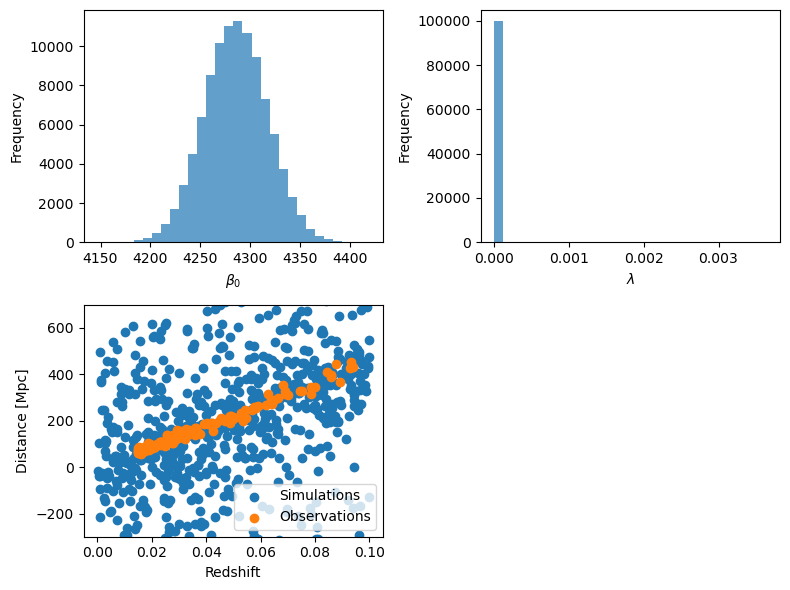

In [54]:
# prior predictive check

n_samples = 100000

# draw beta and lambda
beta_samples = np.random.normal(3e5 / 70, np.sqrt(1e3), size=n_samples)
lambda_samples = np.random.gamma(shape=1e-3, scale=1e-3, size=n_samples)

# draw y
X = np.ones(1)
Y_samples = []
for i in range(n_samples):
    beta = beta_samples[i]
    lambda_ = lambda_samples[i]

    X[0] = (i + 1)*0.1/n_samples # X doesn't need to be random
    Y = np.random.normal(loc=X * beta, scale=1/np.sqrt(lambda_), size=1)
    Y_samples.append(Y)
Y_samples = np.array(Y_samples)



plt.figure(figsize=(8, 6))

# samples of beta
plt.subplot(2, 2, 1)
plt.hist(beta_samples, bins=30, alpha=0.7)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Frequency')

# samples of lambda
plt.subplot(2, 2, 2)
plt.hist(lambda_samples, bins=30, alpha=0.7)
plt.xlabel(r'$\lambda$')
plt.ylabel('Frequency')

# samples of y
plt.subplot(2, 2, 3)
plt.scatter(np.linspace(0, 0.1, n_samples + 1)[1:], Y_samples, label='Simulations')
plt.scatter(local_data.iloc[:, 0], local_data.iloc[:, 1], label='Observations')
plt.ylim(-300, 700)
plt.xlabel('Redshift')
plt.ylabel('Distance [Mpc]')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Gibbs sampler

n_samples = int(1e5)

# prior parameters (we choose the mean according to the MLE)
m = 3e5 / 70
c = 1e-3
a = 1e-3
b = 1e-3

# initial values
beta = beta_MLE
lambda_ = lambda_MLE

shape = a + n / 2

beta_samples = []
lambda_samples = []

for i in range(n_samples):
    # beta | lambda, Y, X
    cov = np.linalg.inv(c * np.eye(p) + lambda_ * X.T @ X)
    mean = cov @ (lambda_ * X.T @ Y + c * m)
    beta = (stats.multivariate_normal.rvs(mean=mean, cov=cov))
    beta = np.array(beta).reshape(-1, 1)

    # lambda | beta, Y, X
    scale = 2 / (2 * b + (Y - X @ beta).T @ (Y - X @ beta)) # note the difference in convention for SciPy
    lambda_ = stats.gamma.rvs(a=shape, scale=scale)

    beta_samples.append(beta)
    lambda_samples.append(lambda_)

beta_samples = np.array(beta_samples).reshape(-1, 1)
lambda_samples = np.array(lambda_samples)

Posterior mean: 4399.375376581182


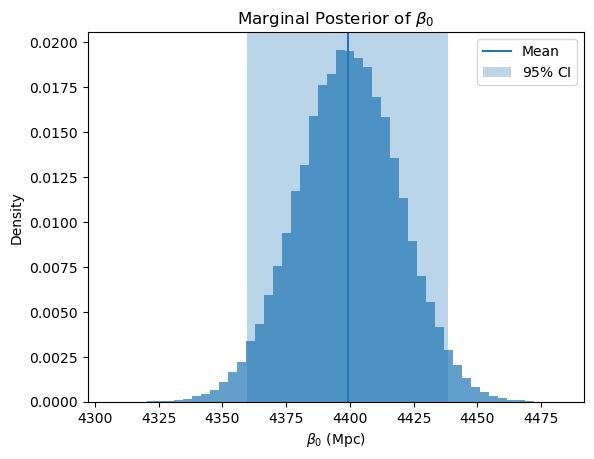

Posterior mean: 0.005512712814321923


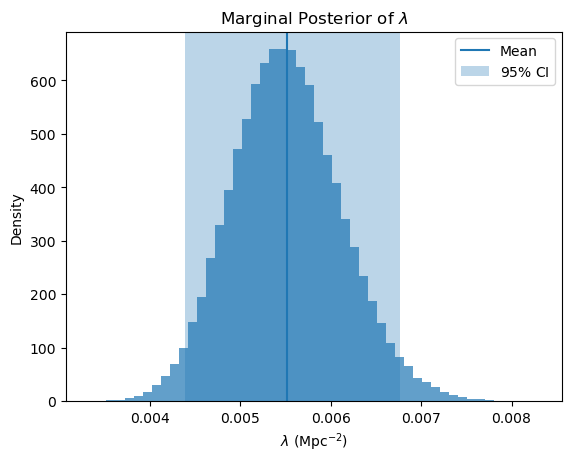

In [ ]:
# results

# beta
beta_mean = np.zeros(p)
for i in range(p):
    beta_mean[i] = beta_samples[:, i].mean()
    beta1_CI = np.percentile(beta_samples[:, i], [2.5, 97.5])
    print('Posterior mean:', beta_mean[i])

    plt.figure()
    plt.hist(beta_samples[:, i], bins=50, density=True, alpha=0.7)
    plt.axvline(beta_mean[i], label='Mean')
    plt.axvspan(beta1_CI[0], beta1_CI[1], alpha=0.3, label=r'$95\%$ CI')
    plt.title(rf'Marginal Posterior of $\beta_{i}$')
    plt.xlabel(rf'$\beta_{i}$ (Mpc)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# lambda
lambda_mean = lambda_samples.mean()
lambda_CI = np.percentile(lambda_samples, [2.5, 97.5])
print('Posterior mean:', lambda_mean)

plt.figure()
plt.hist(lambda_samples, bins=50, density=True, alpha=0.7)
plt.axvline(lambda_mean, label='Mean')
plt.axvspan(lambda_CI[0], lambda_CI[1], alpha=0.3, label=r'$95\%$ CI')
plt.title(r'Marginal Posterior of $\lambda$')
plt.xlabel(r'$\lambda$ ($\mathrm{Mpc}^{-2}$)')
plt.ylabel('Density')
plt.legend()
plt.show()

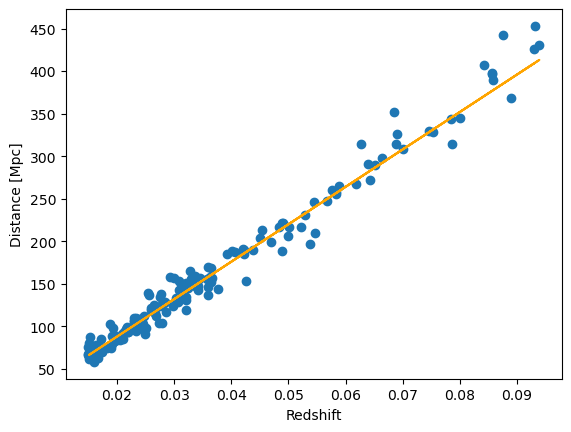

In [62]:
plt.scatter(X, Y)
plt.plot(X, beta_mean*X, color='orange')
plt.xlabel('Redshift')
plt.ylabel('Distance [Mpc]');

Posterior mean: 68.19293007904166 km/s/Mpc
95% credible interval: [67.59087275368879, 68.81425492928533] km/s/Mpc


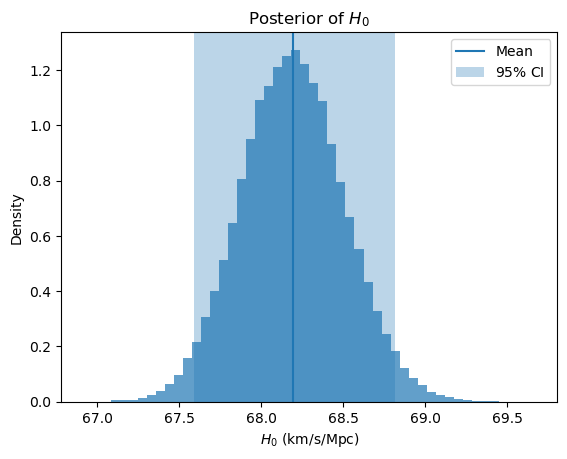

In [ ]:
H0_samples = 3e5 / beta_samples

H0_mean = H0_samples.mean()
H0_CI = np.percentile(H0_samples, [2.5, 97.5])
print(f'Posterior mean: {H0_mean} km/s/Mpc')
print(f'95% credible interval: [{H0_CI[0]}, {H0_CI[1]}] km/s/Mpc')

plt.hist(H0_samples, bins=50, density=True, alpha=0.7)
plt.axvline(H0_mean, label='Mean')
plt.axvspan(H0_CI[0], H0_CI[1], alpha=0.3, label=r'$95\%$ CI')
plt.title(r'Posterior of $H_0$')
plt.xlabel(r'$H_0$ ($\mathrm{km}/\mathrm{s}/\mathrm{Mpc}$)')
plt.ylabel('Density')
plt.legend()
plt.show()

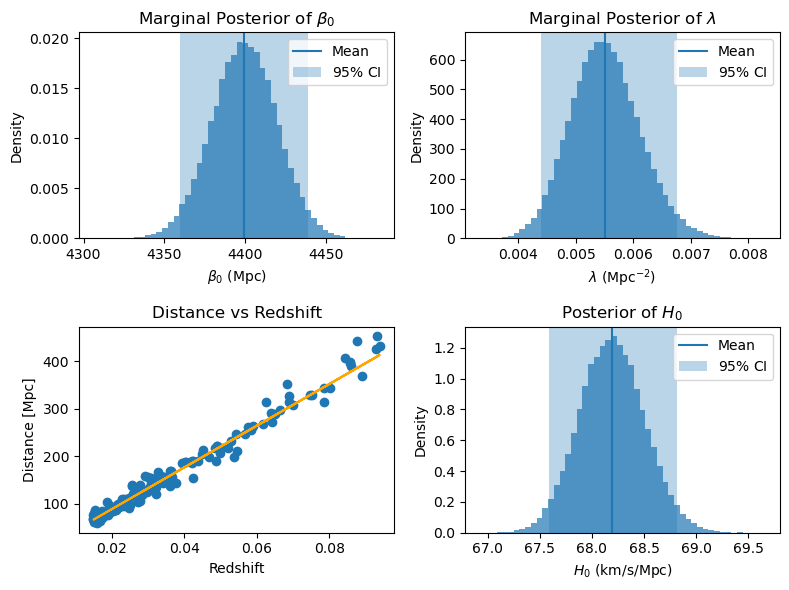

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

# Marginal posterior of beta
for i in range(p):
    beta_mean[i] = beta_samples[:, i].mean()
    beta1_CI = np.percentile(beta_samples[:, i], [2.5, 97.5])
    axs[0].hist(beta_samples[:, i], bins=50, density=True, alpha=0.7)
    axs[0].axvline(beta_mean[i], label='Mean')
    axs[0].axvspan(beta1_CI[0], beta1_CI[1], alpha=0.3, label=r'$95\%$ CI')
    axs[0].set_title(rf'Marginal Posterior of $\beta_{i}$')
    axs[0].set_xlabel(rf'$\beta_{i}$ (Mpc)')
    axs[0].set_ylabel('Density')
    axs[0].legend()

# Marginal posterior of lambda
lambda_mean = lambda_samples.mean()
lambda_CI = np.percentile(lambda_samples, [2.5, 97.5])
axs[1].hist(lambda_samples, bins=50, density=True, alpha=0.7)
axs[1].axvline(lambda_mean, label='Mean')
axs[1].axvspan(lambda_CI[0], lambda_CI[1], alpha=0.3, label=r'$95\%$ CI')
axs[1].set_title(r'Marginal Posterior of $\lambda$')
axs[1].set_xlabel(r'$\lambda$ ($\mathrm{Mpc}^{-2}$)')
axs[1].set_ylabel('Density')
axs[1].legend()

# Best fit line
axs[2].scatter(X, Y)
axs[2].plot(X, beta_mean * X, color='orange')
axs[2].set_xlabel('Redshift')
axs[2].set_ylabel('Distance [Mpc]')
axs[2].set_title('Distance vs Redshift')

# Posterior of H_0
H0_samples = 3e5 / beta_samples.flatten()
H0_mean = H0_samples.mean()
H0_CI = np.percentile(H0_samples, [2.5, 97.5])
axs[3].hist(H0_samples, bins=50, density=True, alpha=0.7)
axs[3].axvline(H0_mean, label='Mean')
axs[3].axvspan(H0_CI[0], H0_CI[1], alpha=0.3, label=r'$95\%$ CI')
axs[3].set_title(r'Posterior of $H_0$')
axs[3].set_xlabel(r'$H_0$ ($\mathrm{km}/\mathrm{s}/\mathrm{Mpc}$)')
axs[3].set_ylabel('Density')
axs[3].legend()

plt.tight_layout()
plt.show()
